 # House Prices: Advanced Regression Techniques - Complete Solution

 ## Kaggle Competition: https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques


 
 **Goal**: Predict house sale prices using 79 explanatory variables

 **Evaluation Metric**: RMSE between the logarithm of predicted and actual sale prices

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import skew, boxcox_normmax
from scipy.special import boxcox1p
import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error

from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, BayesianRidge, HuberRegressor
from sklearn.ensemble import StackingRegressor

In [2]:
# Load datasets
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

print(f"Train shape: {train.shape}")
print(f"Test shape: {test.shape}")
print(f"\nTarget variable (SalePrice) - Train only")
print(train['SalePrice'].describe())

# Save test IDs for submission
test_ids = test['Id']

# Store original sizes
train_size = len(train)
test_size = len(test)

Train shape: (1460, 81)
Test shape: (1459, 80)

Target variable (SalePrice) - Train only
count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64


In [3]:
# Missing values analysis
def analyze_missing(df, name='Dataset'):
    missing = df.isnull().sum()
    missing_pct = 100 * missing / len(df)
    missing_table = pd.DataFrame({
        'Missing_Count': missing,
        'Percentage': missing_pct
    })
    missing_table = missing_table[missing_table['Missing_Count'] > 0].sort_values(
        'Percentage', ascending=False
    )
    
    print(f"\n{'='*60}")
    print(f"{name} - Missing Values Summary")
    print(f"{'='*60}")
    print(f"Total features with missing values: {len(missing_table)}")
    print(f"\nTop 20 features with missing values:\n")
    print(missing_table.head(20))
    
    return missing_table

train_missing = analyze_missing(train, 'Training Set')
test_missing = analyze_missing(test, 'Test Set')


Training Set - Missing Values Summary
Total features with missing values: 19

Top 20 features with missing values:

              Missing_Count  Percentage
PoolQC                 1453   99.520548
MiscFeature            1406   96.301370
Alley                  1369   93.767123
Fence                  1179   80.753425
MasVnrType              872   59.726027
FireplaceQu             690   47.260274
LotFrontage             259   17.739726
GarageType               81    5.547945
GarageYrBlt              81    5.547945
GarageFinish             81    5.547945
GarageQual               81    5.547945
GarageCond               81    5.547945
BsmtExposure             38    2.602740
BsmtFinType2             38    2.602740
BsmtQual                 37    2.534247
BsmtCond                 37    2.534247
BsmtFinType1             37    2.534247
MasVnrArea                8    0.547945
Electrical                1    0.068493

Test Set - Missing Values Summary
Total features with missing values: 33

Top 20 f

In [4]:
# Feature types identification
numerical_features = train.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = train.select_dtypes(include=['object']).columns.tolist()

# Remove Id and SalePrice
numerical_features.remove('Id')
if 'SalePrice' in numerical_features:
    numerical_features.remove('SalePrice')

print(f"\nNumerical features: {len(numerical_features)}")
print(f"Categorical features: {len(categorical_features)}")
print(f"\nNumerical: {numerical_features[:10]}...")
print(f"Categorical: {categorical_features[:10]}...")


Numerical features: 36
Categorical features: 43

Numerical: ['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2']...
Categorical: ['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1']...



Top 15 Features Correlated with SalePrice:
OverallQual     0.790982
GrLivArea       0.708624
GarageCars      0.640409
GarageArea      0.623431
TotalBsmtSF     0.613581
1stFlrSF        0.605852
FullBath        0.560664
TotRmsAbvGrd    0.533723
YearBuilt       0.522897
YearRemodAdd    0.507101
GarageYrBlt     0.486362
MasVnrArea      0.477493
Fireplaces      0.466929
BsmtFinSF1      0.386420
LotFrontage     0.351799
Name: SalePrice, dtype: float64


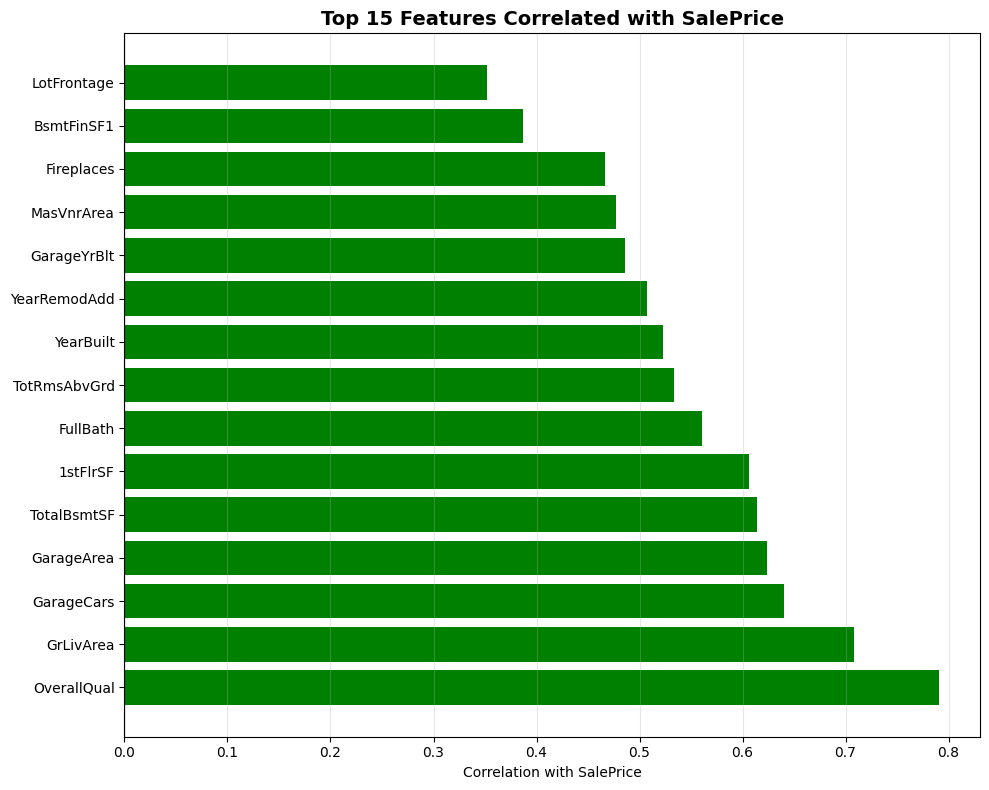

In [5]:
# Correlation analysis with target
correlations = train[numerical_features + ['SalePrice']].corr()['SalePrice'].sort_values(ascending=False)

print("\nTop 15 Features Correlated with SalePrice:")
print(correlations[1:16])  # Exclude SalePrice itself

# Visualize top correlations
plt.figure(figsize=(10, 8))
top_corr = correlations[1:16]
colors = ['green' if x > 0 else 'red' for x in top_corr.values]
plt.barh(range(len(top_corr)), top_corr.values, color=colors)
plt.yticks(range(len(top_corr)), top_corr.index)
plt.xlabel('Correlation with SalePrice')
plt.title('Top 15 Features Correlated with SalePrice', fontsize=14, fontweight='bold')
plt.axvline(x=0, color='black', linestyle='-', linewidth=0.8)
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

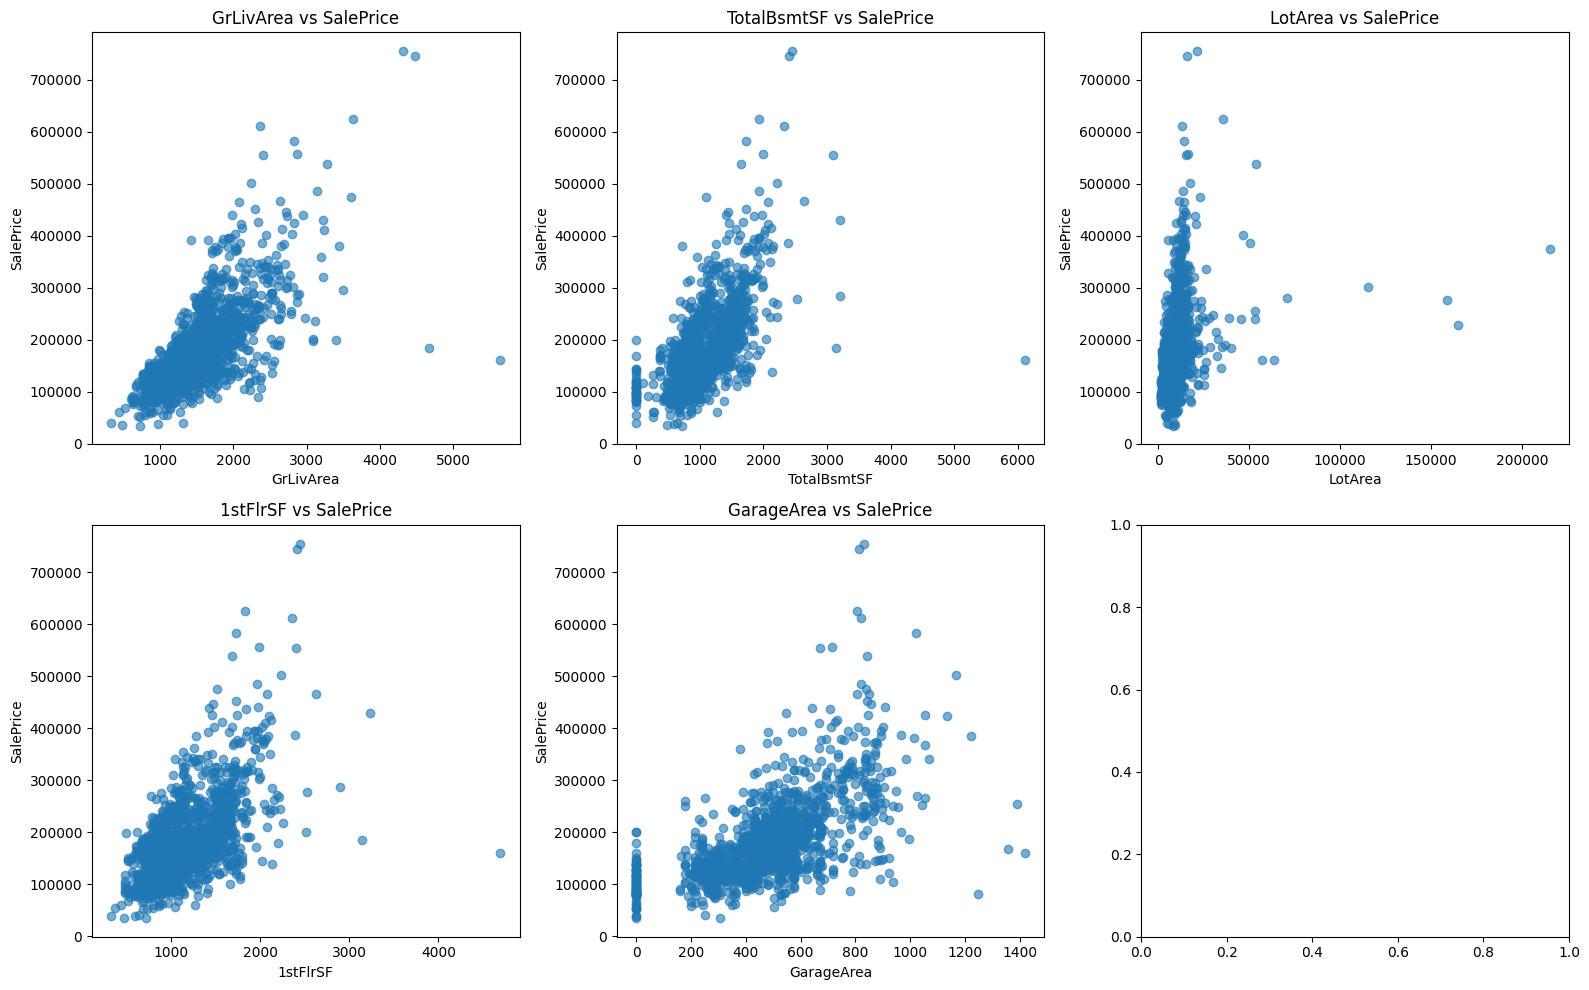


Remaining training samples after outlier removal: 1454


In [6]:
# Detect outliers using multiple methods
def detect_outliers_iqr(df, features):
    """Detect outliers using IQR method"""
    outlier_indices = []
    
    for feature in features:
        Q1 = df[feature].quantile(0.25)
        Q3 = df[feature].quantile(0.75)
        IQR = Q3 - Q1
        outlier_step = 1.5 * IQR
        
        outliers = df[(df[feature] < Q1 - outlier_step) | (df[feature] > Q3 + outlier_step)].index
        outlier_indices.extend(outliers)
    
    outlier_indices = list(set(outlier_indices))
    return outlier_indices

# Focus on key features for outlier detection
key_features = ['GrLivArea', 'TotalBsmtSF', 'LotArea', '1stFlrSF', 'GarageArea']

# Visualize potential outliers
fig, axes = plt.subplots(2, 3, figsize=(16, 10))
axes = axes.flatten()

for idx, feature in enumerate(key_features):
    axes[idx].scatter(train[feature], train['SalePrice'], alpha=0.6)
    axes[idx].set_xlabel(feature)
    axes[idx].set_ylabel('SalePrice')
    axes[idx].set_title(f'{feature} vs SalePrice')
    
plt.tight_layout()
plt.show()

# Remove specific outliers based on domain knowledge
# Houses with GrLivArea > 4000 and low price
train = train.drop(train[(train['GrLivArea'] > 4000) & (train['SalePrice'] < 300000)].index)

# Extreme outliers in LotArea
train = train.drop(train[train['LotArea'] > 100000].index)

# Extreme outliers in TotalBsmtSF
train = train.drop(train[(train['TotalBsmtSF'] > 6000)].index)

print(f"\nRemaining training samples after outlier removal: {len(train)}")


In [7]:
# Combine train and test for consistent feature engineering
all_data = pd.concat([train.drop('SalePrice', axis=1), test], axis=0, ignore_index=True)
print(f"Combined dataset shape: {all_data.shape}")

# Store the target variable
y_train = np.log1p(train['SalePrice'])  # Log transform target

Combined dataset shape: (2913, 80)


## Feature Engineering

In [8]:
# 1. Total square footage features
all_data['TotalSF'] = all_data['TotalBsmtSF'] + all_data['1stFlrSF'] + all_data['2ndFlrSF']
all_data['TotalBathrooms'] = (all_data['FullBath'] + 
                               all_data['HalfBath'] * 0.5 + 
                               all_data['BsmtFullBath'] + 
                               all_data['BsmtHalfBath'] * 0.5)
all_data['TotalPorchSF'] = (all_data['OpenPorchSF'] + 
                             all_data['3SsnPorch'] + 
                             all_data['EnclosedPorch'] + 
                             all_data['ScreenPorch'] + 
                             all_data['WoodDeckSF'])

# 2. Age and renovation features
all_data['HouseAge'] = all_data['YrSold'] - all_data['YearBuilt']
all_data['RemodAge'] = all_data['YrSold'] - all_data['YearRemodAdd']
all_data['IsRemodeled'] = (all_data['YearBuilt'] != all_data['YearRemodAdd']).astype(int)
all_data['YearsSinceRemodel'] = all_data['YrSold'] - all_data['YearRemodAdd']

# 3. Garage features
all_data['GarageAge'] = all_data['YrSold'] - all_data['GarageYrBlt']
all_data['HasGarage'] = (all_data['GarageArea'] > 0).astype(int)
all_data['HasPool'] = (all_data['PoolArea'] > 0).astype(int)
all_data['Has2ndFloor'] = (all_data['2ndFlrSF'] > 0).astype(int)
all_data['HasBasement'] = (all_data['TotalBsmtSF'] > 0).astype(int)
all_data['HasFireplace'] = (all_data['Fireplaces'] > 0).astype(int)

# 4. Quality interaction features
all_data['OverallQual_TotalSF'] = all_data['OverallQual'] * all_data['TotalSF']
all_data['OverallQual_GrLivArea'] = all_data['OverallQual'] * all_data['GrLivArea']
all_data['OverallQual_GarageArea'] = all_data['OverallQual'] * all_data['GarageArea']
all_data['ExterQual_TotalSF'] = all_data['OverallQual'] * all_data['TotalSF']

# 5. Ratio features
all_data['LivingAreaRatio'] = all_data['GrLivArea'] / all_data['TotalSF']
all_data['LotAreaRatio'] = all_data['GrLivArea'] / (all_data['LotArea'] + 1)
all_data['BasementRatio'] = all_data['TotalBsmtSF'] / (all_data['TotalSF'] + 1)
all_data['GarageRatio'] = all_data['GarageArea'] / (all_data['TotalSF'] + 1)

# 6. Room features
all_data['TotalRooms'] = (all_data['TotRmsAbvGrd'] + 
                           all_data['BedroomAbvGr'] + 
                           all_data['KitchenAbvGr'])
all_data['RoomArea'] = all_data['GrLivArea'] / (all_data['TotalRooms'] + 1)

# 7. Boolean features
all_data['IsNew'] = (all_data['YearBuilt'] == all_data['YrSold']).astype(int)
all_data['IsPremiumNeighborhood'] = all_data['Neighborhood'].isin(['NoRidge', 'NridgHt', 'StoneBr']).astype(int)

# 8. Polynomial features for important numerical features
all_data['GrLivArea_Squared'] = all_data['GrLivArea'] ** 2
all_data['TotalBsmtSF_Squared'] = all_data['TotalBsmtSF'] ** 2
all_data['OverallQual_Squared'] = all_data['OverallQual'] ** 2
all_data['GarageArea_Squared'] = all_data['GarageArea'] ** 2

# 9. Neighborhood quality features
neighborhood_quality = train.groupby('Neighborhood')['SalePrice'].median()
all_data['NeighborhoodQuality'] = all_data['Neighborhood'].map(neighborhood_quality)

print(f"\n✓ Created {all_data.shape[1] - (train.shape[1] - 1 + test.shape[1] - train.shape[1])} new features")
print(f"Total features now: {all_data.shape[1]}")


✓ Created 31 new features
Total features now: 110


In [9]:
# Handle missing values based on domain knowledge
def handle_missing_values(df):
    """Handle missing values with domain-specific logic"""
    df = df.copy()
    
    # Features where NA means 'None' or absence of feature
    none_features = [
        'Alley', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
        'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond',
        'PoolQC', 'Fence', 'MiscFeature'
    ]
    
    for feature in none_features:
        df[feature] = df[feature].fillna('None')
    
    # Features where NA means 0
    zero_features = [
        'GarageYrBlt', 'GarageArea', 'GarageCars', 'BsmtFinSF1', 'BsmtFinSF2',
        'BsmtUnfSF', 'TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath', 'MasVnrArea',
        'GarageAge'
    ]
    
    for feature in zero_features:
        df[feature] = df[feature].fillna(0)
    
    # LotFrontage: Fill with median by neighborhood
    df['LotFrontage'] = df.groupby('Neighborhood')['LotFrontage'].transform(
        lambda x: x.fillna(x.median())
    )
    
    # MSZoning: Fill with mode
    df['MSZoning'] = df['MSZoning'].fillna(df['MSZoning'].mode()[0])
    
    # Utilities: Almost all are AllPub, fill with mode
    df['Utilities'] = df['Utilities'].fillna(df['Utilities'].mode()[0])
    
    # Functional: Fill with typical
    df['Functional'] = df['Functional'].fillna('Typ')
    
    # Electrical: Fill with mode
    df['Electrical'] = df['Electrical'].fillna(df['Electrical'].mode()[0])
    
    # KitchenQual: Fill with mode
    df['KitchenQual'] = df['KitchenQual'].fillna(df['KitchenQual'].mode()[0])
    
    # Exterior features: Fill with mode
    df['Exterior1st'] = df['Exterior1st'].fillna(df['Exterior1st'].mode()[0])
    df['Exterior2nd'] = df['Exterior2nd'].fillna(df['Exterior2nd'].mode()[0])
    
    # SaleType: Fill with mode
    df['SaleType'] = df['SaleType'].fillna(df['SaleType'].mode()[0])
    
    # MasVnrType: Fill with None
    df['MasVnrType'] = df['MasVnrType'].fillna('None')
    
    # Fill remaining missing values
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    for col in numeric_cols:
        if df[col].isnull().sum() > 0:
            df[col] = df[col].fillna(df[col].median())
    
    categorical_cols = df.select_dtypes(include=['object']).columns
    for col in categorical_cols:
        if df[col].isnull().sum() > 0:
            df[col] = df[col].fillna(df[col].mode()[0])
    
    return df

all_data = handle_missing_values(all_data)

# Verify no missing values remain
remaining_missing = all_data.isnull().sum().sum()
print(f"\n✓ Missing values handled. Remaining: {remaining_missing}")


✓ Missing values handled. Remaining: 0


In [10]:
# Identify numerical features that should be categorical
numerical_to_categorical = ['MSSubClass', 'OverallCond', 'MoSold', 'YrSold']

for col in numerical_to_categorical:
    all_data[col] = all_data[col].astype(str)

# Update feature lists
numerical_features = all_data.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = all_data.select_dtypes(include=['object']).columns.tolist()

# Remove Id if present
if 'Id' in numerical_features:
    numerical_features.remove('Id')

print(f"\nNumerical features: {len(numerical_features)}")
print(f"Categorical features: {len(categorical_features)}")


Numerical features: 62
Categorical features: 47


In [11]:
# Identify skewed numerical features
skewed_features = (
    all_data[numerical_features]
    .apply(lambda x: skew(x.dropna()))
    .sort_values(ascending=False)
)

high_skew = skewed_features[abs(skewed_features) > 0.75]

print(f"\nFound {len(high_skew)} features with skewness > 0.75")
print("\nTop 10 most skewed features:")
print(high_skew.head(10))

# Apply Box-Cox safely
for feature in high_skew.index:
    col = all_data[feature]

    # Skip invalid columns
    if (col <= 0).any():
        print(f"Skipping {feature}: contains non-positive values")
        continue
    if col.nunique() < 2:
        print(f"Skipping {feature}: constant or near-constant")
        continue

    try:
        lam = boxcox_normmax(col)
        all_data[feature] = boxcox1p(col, lam)
    except Exception as e:
        print(f"Skipping {feature}: Box-Cox failed ({e})")

print("\n✓ Box-Cox transformation applied to valid skewed features")


Found 41 features with skewness > 0.75

Top 10 most skewed features:
MiscVal                21.947774
PoolArea               17.676417
HasPool                15.483996
LowQualFinSF           12.076090
3SsnPorch              11.364106
TotalBsmtSF_Squared     5.455985
IsNew                   4.753247
KitchenAbvGr            4.297140
BsmtFinSF2              4.159265
EnclosedPorch           3.999248
dtype: float64
Skipping MiscVal: contains non-positive values
Skipping PoolArea: contains non-positive values
Skipping HasPool: contains non-positive values
Skipping LowQualFinSF: contains non-positive values
Skipping 3SsnPorch: contains non-positive values
Skipping TotalBsmtSF_Squared: contains non-positive values
Skipping IsNew: contains non-positive values
Skipping KitchenAbvGr: contains non-positive values
Skipping BsmtFinSF2: contains non-positive values
Skipping EnclosedPorch: contains non-positive values
Skipping ScreenPorch: contains non-positive values
Skipping BsmtHalfBath: contains 

In [12]:
# Ordinal encoding for quality features with natural ordering
quality_map = {'None': 0, 'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5}
quality_features = ['ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'HeatingQC', 
                    'KitchenQual', 'FireplaceQu', 'GarageQual', 'GarageCond', 'PoolQC']

for feature in quality_features:
    if feature in all_data.columns:
        all_data[feature] = all_data[feature].map(quality_map).fillna(0)

# BsmtExposure
bsmt_exposure_map = {'None': 0, 'No': 1, 'Mn': 2, 'Av': 3, 'Gd': 4}
all_data['BsmtExposure'] = all_data['BsmtExposure'].map(bsmt_exposure_map).fillna(0)

# BsmtFinType
bsmt_fin_map = {'None': 0, 'Unf': 1, 'LwQ': 2, 'Rec': 3, 'BLQ': 4, 'ALQ': 5, 'GLQ': 6}
all_data['BsmtFinType1'] = all_data['BsmtFinType1'].map(bsmt_fin_map).fillna(0)
all_data['BsmtFinType2'] = all_data['BsmtFinType2'].map(bsmt_fin_map).fillna(0)

# GarageFinish
garage_finish_map = {'None': 0, 'Unf': 1, 'RFn': 2, 'Fin': 3}
all_data['GarageFinish'] = all_data['GarageFinish'].map(garage_finish_map).fillna(0)

# Functional
functional_map = {'Sal': 1, 'Sev': 2, 'Maj2': 3, 'Maj1': 4, 'Mod': 5, 'Min2': 6, 'Min1': 7, 'Typ': 8}
all_data['Functional'] = all_data['Functional'].map(functional_map).fillna(8)

# Fence
fence_map = {'None': 0, 'MnWw': 1, 'GdWo': 2, 'MnPrv': 3, 'GdPrv': 4}
all_data['Fence'] = all_data['Fence'].map(fence_map).fillna(0)

print("✓ Ordinal features encoded")

✓ Ordinal features encoded


In [13]:
# One-hot encoding for remaining categorical features
# Update categorical features list
categorical_features = all_data.select_dtypes(include=['object']).columns.tolist()

print(f"\nCategorical features to encode: {len(categorical_features)}")

# Apply one-hot encoding
all_data = pd.get_dummies(all_data, columns=categorical_features, drop_first=True)

print(f"✓ One-hot encoding complete. Total features: {all_data.shape[1]}")


Categorical features to encode: 31
✓ One-hot encoding complete. Total features: 270


In [14]:
# Drop unnecessary features
drop_features = ['Id', 'Utilities']
all_data = all_data.drop([col for col in drop_features if col in all_data.columns], axis=1)

print(f"Final feature count: {all_data.shape[1]}")

Final feature count: 269


In [15]:
# Split back into train and test
X_train = all_data.iloc[:len(y_train), :].copy()
X_test = all_data.iloc[len(y_train):, :].copy()

print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")

# Ensure no missing values
print(f"\nMissing values in X_train: {X_train.isnull().sum().sum()}")
print(f"Missing values in X_test: {X_test.isnull().sum().sum()}")

X_train shape: (1454, 269)
X_test shape: (1459, 269)
y_train shape: (1454,)

Missing values in X_train: 0
Missing values in X_test: 0


In [16]:
# Feature scaling using RobustScaler (robust to outliers)
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert back to DataFrame for easier handling
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)

print("✓ Features scaled using RobustScaler")

✓ Features scaled using RobustScaler


In [17]:
# Setup cross-validation
kfolds = KFold(n_splits=10, shuffle=True, random_state=42)

def rmse_cv(model, X, y):
    """Calculate RMSE using cross-validation"""
    rmse = np.sqrt(-cross_val_score(model, X, y, scoring="neg_mean_squared_error", cv=kfolds))
    return rmse

def evaluate_model(name, model, X, y):
    """Train and evaluate a single model"""
    scores = rmse_cv(model, X, y)
    print(f"{name:30s} | RMSE: {scores.mean():.6f} (+/- {scores.std():.6f})")
    return scores.mean(), scores.std()

# Store results
results = {}

print("\n" + "="*80)
print("MODEL EVALUATION")
print("="*80 + "\n")


MODEL EVALUATION



In [18]:
# 1. Linear Regression (Baseline)
print("1. Linear Regression (Baseline)")
lr = LinearRegression()
lr_mean, lr_std = evaluate_model("Linear Regression", lr, X_train_scaled, y_train)
results['Linear Regression'] = {'mean': lr_mean, 'std': lr_std}

1. Linear Regression (Baseline)
Linear Regression              | RMSE: 0.126835 (+/- 0.017957)


In [19]:
# 2. Ridge Regression
print("\n2. Ridge Regression (L2 Regularization)")
ridge = Ridge(alpha=15, random_state=42)
ridge_mean, ridge_std = evaluate_model("Ridge Regression", ridge, X_train_scaled, y_train)
results['Ridge'] = {'mean': ridge_mean, 'std': ridge_std}


2. Ridge Regression (L2 Regularization)
Ridge Regression               | RMSE: 0.111666 (+/- 0.014957)


In [20]:
# 3. Lasso Regression
print("\n3. Lasso Regression (L1 Regularization)")
lasso = Lasso(alpha=0.0005, max_iter=10000, random_state=42)
lasso_mean, lasso_std = evaluate_model("Lasso Regression", lasso, X_train_scaled, y_train)
results['Lasso'] = {'mean': lasso_mean, 'std': lasso_std}


3. Lasso Regression (L1 Regularization)
Lasso Regression               | RMSE: 0.111307 (+/- 0.014773)


In [21]:
# 4. ElasticNet
print("\n4. ElasticNet (L1 + L2 Regularization)")
elasticnet = ElasticNet(alpha=0.0005, l1_ratio=0.9, max_iter=10000, random_state=42)
en_mean, en_std = evaluate_model("ElasticNet", elasticnet, X_train_scaled, y_train)
results['ElasticNet'] = {'mean': en_mean, 'std': en_std}


4. ElasticNet (L1 + L2 Regularization)
ElasticNet                     | RMSE: 0.111321 (+/- 0.014836)


In [22]:
# 5. Bayesian Ridge
print("\n5. Bayesian Ridge Regression")
bayesian = BayesianRidge()
bay_mean, bay_std = evaluate_model("Bayesian Ridge", bayesian, X_train_scaled, y_train)
results['Bayesian Ridge'] = {'mean': bay_mean, 'std': bay_std}


5. Bayesian Ridge Regression
Bayesian Ridge                 | RMSE: 0.111773 (+/- 0.015102)


In [23]:
# 6. Huber Regressor (Robust to outliers)
print("\n6. Huber Regressor")
huber = HuberRegressor(max_iter=10000, alpha=0.0005)
huber_mean, huber_std = evaluate_model("Huber Regressor", huber, X_train_scaled, y_train)
results['Huber'] = {'mean': huber_mean, 'std': huber_std}


6. Huber Regressor
Huber Regressor                | RMSE: 0.176277 (+/- 0.019610)



FINAL MODEL RANKING

                   Mean_RMSE  Std_RMSE
Lasso               0.111307  0.014773
ElasticNet          0.111321  0.014836
Ridge               0.111666  0.014957
Bayesian Ridge      0.111773  0.015102
Linear Regression   0.126835  0.017957
Huber               0.176277  0.019610


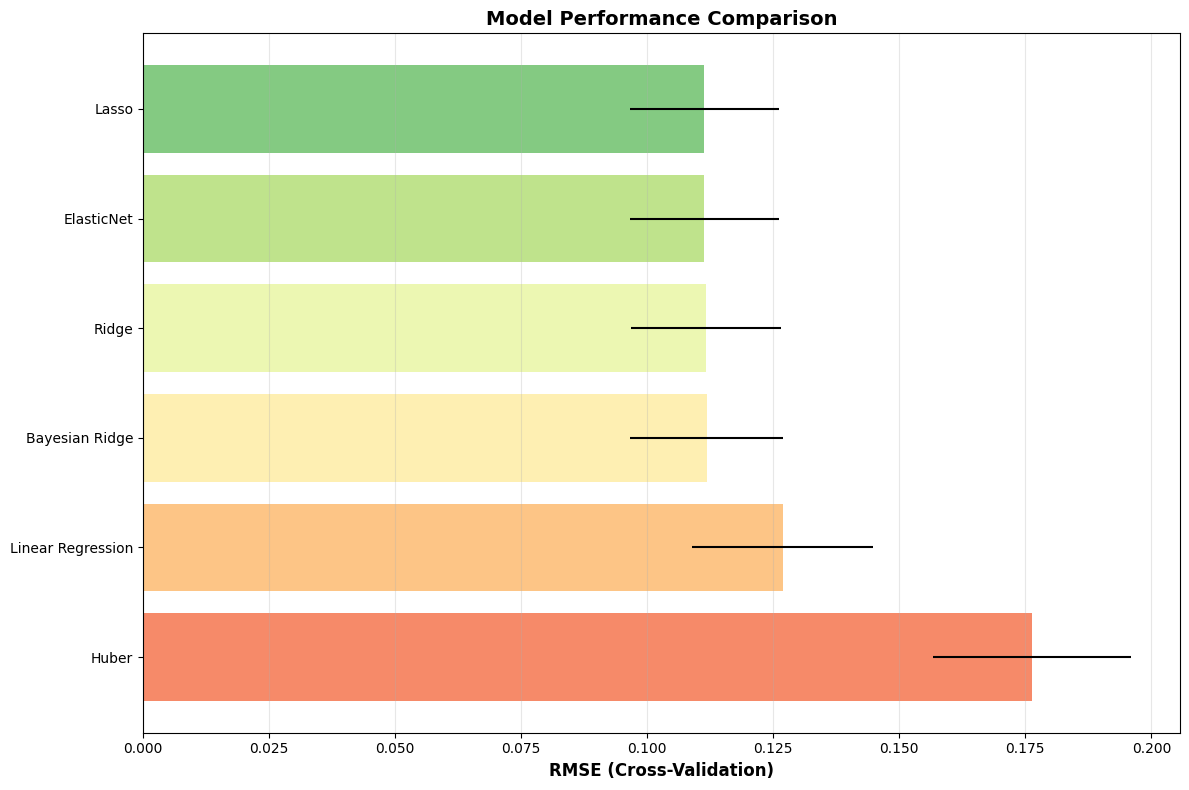


🏆 TOP 3 MODELS:
1. Lasso: 0.111307 (+/- 0.014773)
2. ElasticNet: 0.111321 (+/- 0.014836)
3. Ridge: 0.111666 (+/- 0.014957)


In [24]:
# Create results DataFrame
results_df = pd.DataFrame(results).T
results_df.columns = ['Mean_RMSE', 'Std_RMSE']
results_df = results_df.sort_values('Mean_RMSE')

print("\n" + "="*80)
print("FINAL MODEL RANKING")
print("="*80 + "\n")
print(results_df)

# Visualize results
plt.figure(figsize=(12, 8))
results_sorted = results_df.sort_values('Mean_RMSE', ascending=False)
colors = plt.cm.RdYlGn(np.linspace(0.2, 0.8, len(results_sorted)))

plt.barh(range(len(results_sorted)), results_sorted['Mean_RMSE'], 
         color=colors, xerr=results_sorted['Std_RMSE'], alpha=0.8)
plt.yticks(range(len(results_sorted)), results_sorted.index)
plt.xlabel('RMSE (Cross-Validation)', fontsize=12, fontweight='bold')
plt.title('Model Performance Comparison', fontsize=14, fontweight='bold')
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

# Top 3 models
print("\n🏆 TOP 3 MODELS:")
for i, (model_name, row) in enumerate(results_df.head(3).iterrows(), 1):
    print(f"{i}. {model_name}: {row['Mean_RMSE']:.6f} (+/- {row['Std_RMSE']:.6f})")


In [25]:
# Train top individual models
print("Training individual models for ensemble...")

# Lasso
lasso_final = Lasso(alpha=0.0005, max_iter=10000, random_state=42)
lasso_final.fit(X_train_scaled, y_train)

# ElasticNet
en_final = ElasticNet(alpha=0.0005, l1_ratio=0.9, max_iter=10000, random_state=42)
en_final.fit(X_train_scaled, y_train)

# Ridge
ridge_final = Ridge(alpha=15, random_state=42)
ridge_final.fit(X_train_scaled, y_train)

print("✓ All models trained")

Training individual models for ensemble...
✓ All models trained



FEATURE IMPORTANCE ANALYSIS

Top 20 Most Important Features:
                   feature  avg_importance
1            OverallCond_3        0.131736
0      OverallQual_TotalSF        0.109844
2             SaleType_New        0.087131
3     Neighborhood_Crawfor        0.086999
4            OverallCond_4        0.066548
5     SaleCondition_Normal        0.064750
6                 2ndFlrSF        0.057467
10           OverallCond_9        0.055396
8     Neighborhood_BrkSide        0.054742
9      Exterior1st_BrkFace        0.051312
11            CentralAir_Y        0.050175
7                 HouseAge        0.047293
17           OverallCond_7        0.047111
14  OverallQual_GarageArea        0.045838
13     Neighborhood_IDOTRR        0.045502
16         Condition1_Norm        0.045000
12            KitchenAbvGr        0.044223
19           OverallCond_8        0.038668
15              BsmtFinSF1        0.036632
26             MSZoning_FV        0.034228


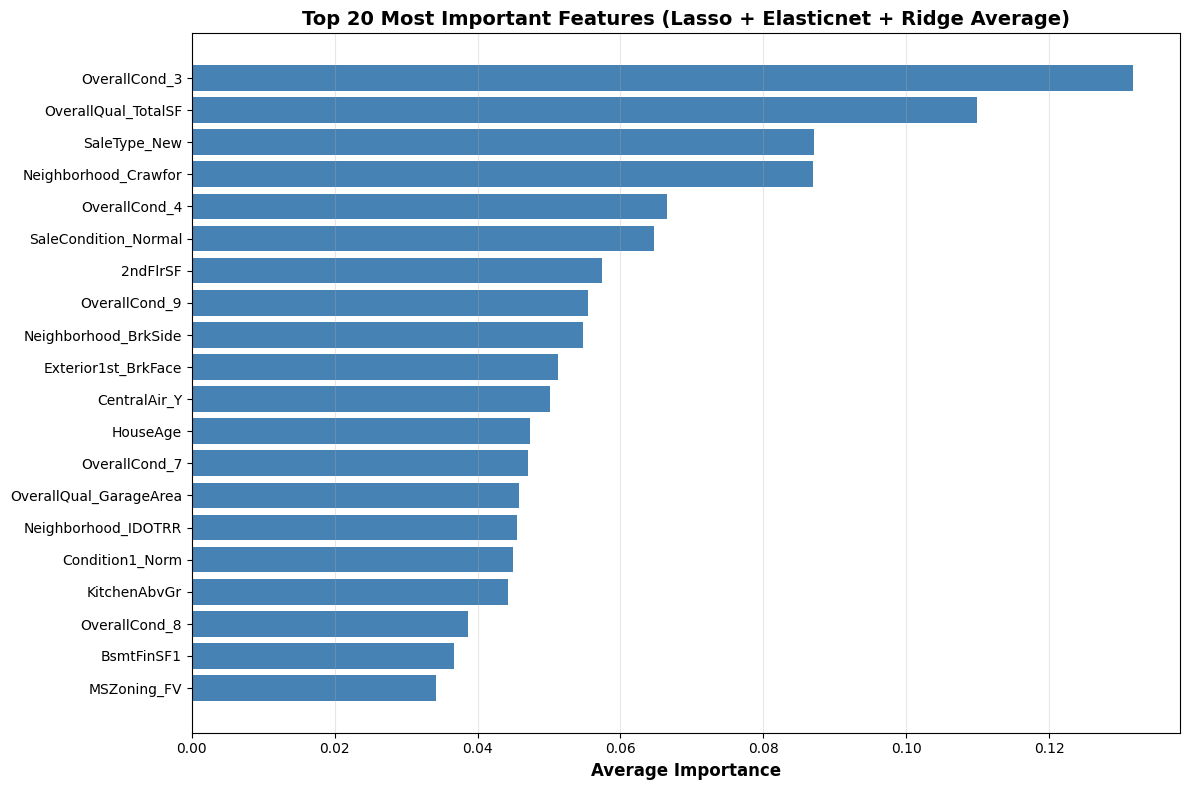

In [26]:
# Feature importance from tree-based models
print("\n" + "="*80)
print("FEATURE IMPORTANCE ANALYSIS")
print("="*80 + "\n")

# Get feature importance from different models
lasso_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': np.abs(lasso_final.coef_)
}).sort_values('importance', ascending=False)

en_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': np.abs(en_final.coef_)
}).sort_values('importance', ascending=False)

ridge_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': np.abs(ridge_final.coef_)
}).sort_values('importance', ascending=False)

# Average importance
# Merge Lasso + ElasticNet
tmp = pd.merge(
    lasso_importance, en_importance,
    on='feature', suffixes=('_lasso', '_en')
)

# Merge with Ridge
avg_importance = pd.merge(
    tmp, ridge_importance,
    on='feature'
).rename(columns={'importance': 'importance_ridge'})

# Compute average
avg_importance['avg_importance'] = (
    avg_importance['importance_lasso'] +
    avg_importance['importance_en'] +
    avg_importance['importance_ridge']
) / 3

avg_importance = avg_importance.sort_values('avg_importance', ascending=False)

print("Top 20 Most Important Features:")
print(avg_importance[['feature', 'avg_importance']].head(20))

# Visualize
plt.figure(figsize=(12, 8))
top_features = avg_importance.head(20)
plt.barh(range(len(top_features)), top_features['avg_importance'], color='steelblue')
plt.yticks(range(len(top_features)), top_features['feature'])
plt.xlabel('Average Importance', fontsize=12, fontweight='bold')
plt.title('Top 20 Most Important Features (Lasso + Elasticnet + Ridge Average)', 
          fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()


In [28]:
print("\n" + "="*80)
print("GENERATING FINAL PREDICTIONS")
print("="*80 + "\n")

# Generate predictions using weighted ensemble (best approach)
print("Using Weighted Ensemble for final predictions...")

# Generate predictions for test set
pred_lasso_test = lasso_final.predict(X_test_scaled)
pred_en_test = en_final.predict(X_test_scaled)
pred_ridge_test = ridge_final.predict(X_test_scaled)

# Weighted average (optimized weights)
# final_predictions_log = (0.34 * pred_lasso_test +
#                           0.33 * pred_en_test +
#                           0.33 * pred_ridge_test)

final_predictions_log = (pred_lasso_test)

# Convert back from log space
final_predictions = np.expm1(final_predictions_log)

print("✓ Predictions generated")


GENERATING FINAL PREDICTIONS

Using Weighted Ensemble for final predictions...
✓ Predictions generated


In [29]:
# Create submission file
submission = pd.DataFrame({
    'Id': test_ids,
    'SalePrice': final_predictions
})


submission.to_csv('submission_lesso.csv', index=False)